In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.score_net import ScoreNet
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path

# Guiding conditional cell diffusion process
We now exam a cell differentiation and development model from _Quantifying the Waddington landscape and biological paths for development and differentiation. Wang et.al._, which is a two-dimensional diffusion process governed by the pair of 1D SDEs:
$$
\mathrm{d}X_{t,1} = \left\{\frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} + \frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} - X_{t,1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,1} \\
\mathrm{d}X_{t,2} = \left\{\frac{X^4_{t,2}}{2^{-4} + X^4_{t,2}} + \frac{X^4_{t,1}}{2^{-4} + X^4_{t,1}} - X_{t,2}\right\}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a highly nonlinear process with no closed-form solution of conditional bridges. We choose the linear auxiliary process as:
$$
\mathrm{d}\tilde{X}_{t,1} = - \tilde{X}_{t,1}\mathrm{d}t + \sigma\mathrm{d}W_{t,1}\\
\mathrm{d}\tilde{X}_{t,2} = - \tilde{X}_{t,2}\mathrm{d}t + \sigma\mathrm{d}W_{t,2},
$$
which is a 2D Ornstein-Uhlenbeck process.

In [3]:
dim = 2
T = 4.0
dt = 1.0 / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, -0.1], dtype=dtype)
v = jnp.array([2.0, -0.1], dtype=dtype)
# v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
ori_proc = CellDiffusionProcess(alpha, sigma, T, dim, dtype)
aux_proc = CellDiffusionAuxProcess(alpha, sigma, T, dim, dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)
guided_bridge_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

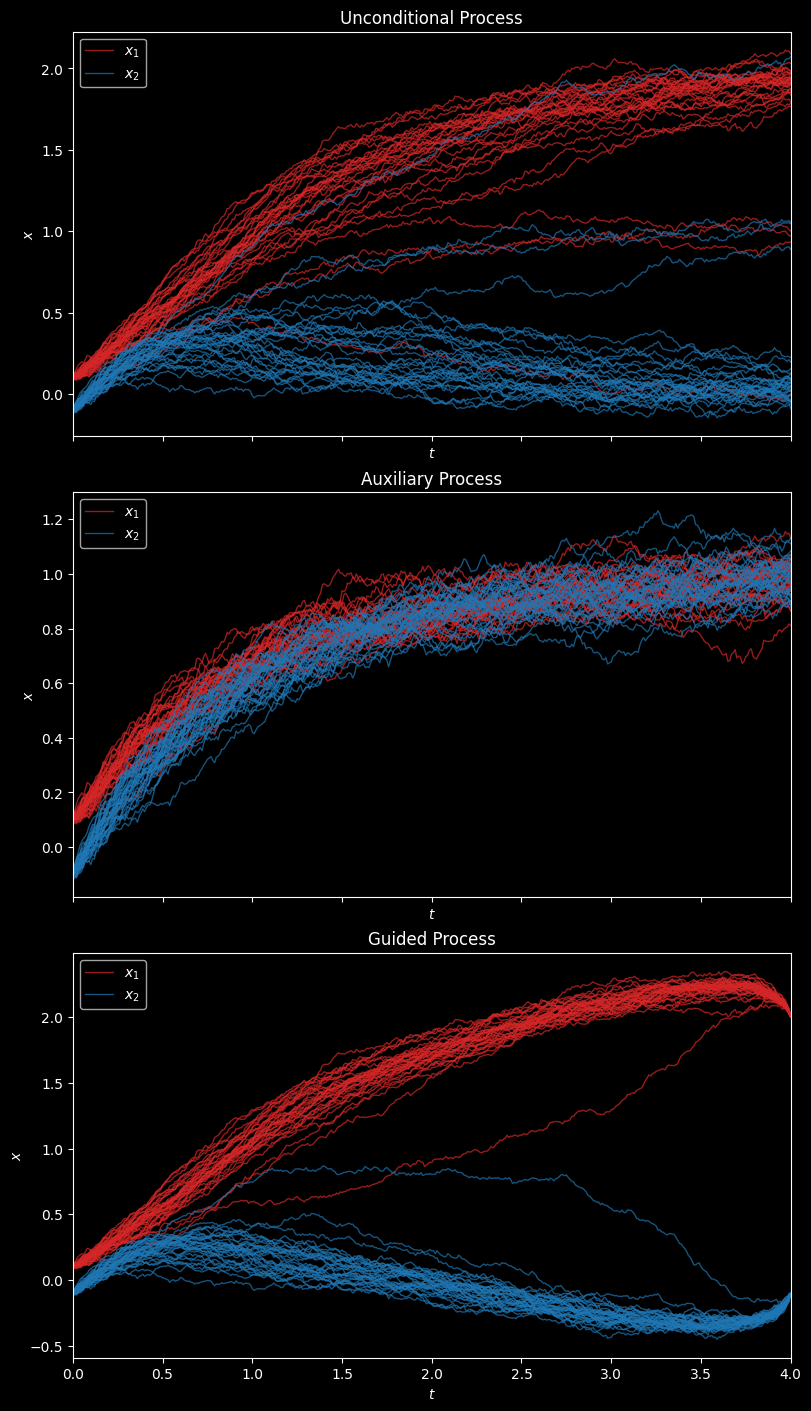

In [5]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_bridge_path = guided_bridge_solver.solve(x0=u, 
                                                rng_key=rng_key, 
                                                batch_size=batch_size, 
                                                enforce_end_point=v
                                            )

fig, axes = plt.subplots(3, 1, figsize=(8, 14), layout="constrained", sharex=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_bridge_path, ax=axes[2], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [6]:
net = ScoreNet(out_dim=dim, 
               hidden_dims=(32, 64, 32),
               norm="batch",
               t_emb_dim=32,
               t_emb_max_period=500.0,
               t_emb_scaling=100.0)

In [7]:
train_config = {
    "save_name": "cell_model_normalized_ll",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 128,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [8]:
model = neurb.NeuralBridge(guided_proc, net, train_config)

In [9]:
model.initialize_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_normalized_ll
INFO:root:Loading pretrained model from the last epoch


In [10]:
neural_bridge = model.build_neural_bridge()

In [11]:
neural_bridge_solver = Euler(neural_bridge, wiener_proc)
neural_bridge_path = neural_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [13]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=1000)

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Iteration 0/10000: log likelihood = 169.13661193847656
INFO:root:Iteration 1000/10000: log likelihood = 293.79364013671875
INFO:root:Iteration 2000/10000: log likelihood = 286.0283508300781
INFO:root:Iteration 3000/10000: log likelihood = 290.6103515625
INFO:root:Iteration 4000/10000: log likelihood = 282.71624755859375
INFO:root:Iteration 5000/10000: log likelihood = 261.9419860839844
INFO:root:Iteration 6000/10000: log likelihood = 293.9814758300781
INFO:root:Iteration 7000/10000: log likelihood = 275.2231750488281
INFO:root:Iteration 8000/10000: log likelihood = 281.37481689453125
INFO:root:Iteration 9000/10000: log likelihood = 250.9185028076172
INFO:root:Batch average acceptance rate: 28.11%


In [24]:
sm_train_config = {
    "save_name": "cell_model",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 64,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [25]:
net = ScoreNet(out_dim=dim, 
               hidden_dims=(32, 64, 32),
               norm="batch",
               t_emb_dim=32,
               t_emb_max_period=500.0,
               t_emb_scaling=100.0)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(ori_proc, net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(wiener_proc)
losses = sm_reverse_bridge.train_reversed_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: 799.22778
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_1


Epoch 2:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: 797.69635
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_2


Epoch 3:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: 797.52216
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_3


Epoch 4:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: 796.95239
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_4


Epoch 5:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: 796.06396
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_5


Epoch 6:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: 795.72052
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_6


Epoch 7:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: 795.17139
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_7


Epoch 8:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: 794.64746
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_8


Epoch 9:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: 794.81812
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_9


Epoch 10:   0%|          | 0/500 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: 795.07477
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model/epoch_10


In [29]:
reversed_bridge = sm_reverse_bridge.build_reversed_bridge()
reversed_bridge_solver = Euler(reversed_bridge, wiener_proc)
reversed_bridge_path = reversed_bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

<Axes: title={'center': 'Reversed Bridge'}, xlabel='$t$', ylabel='$x$'>

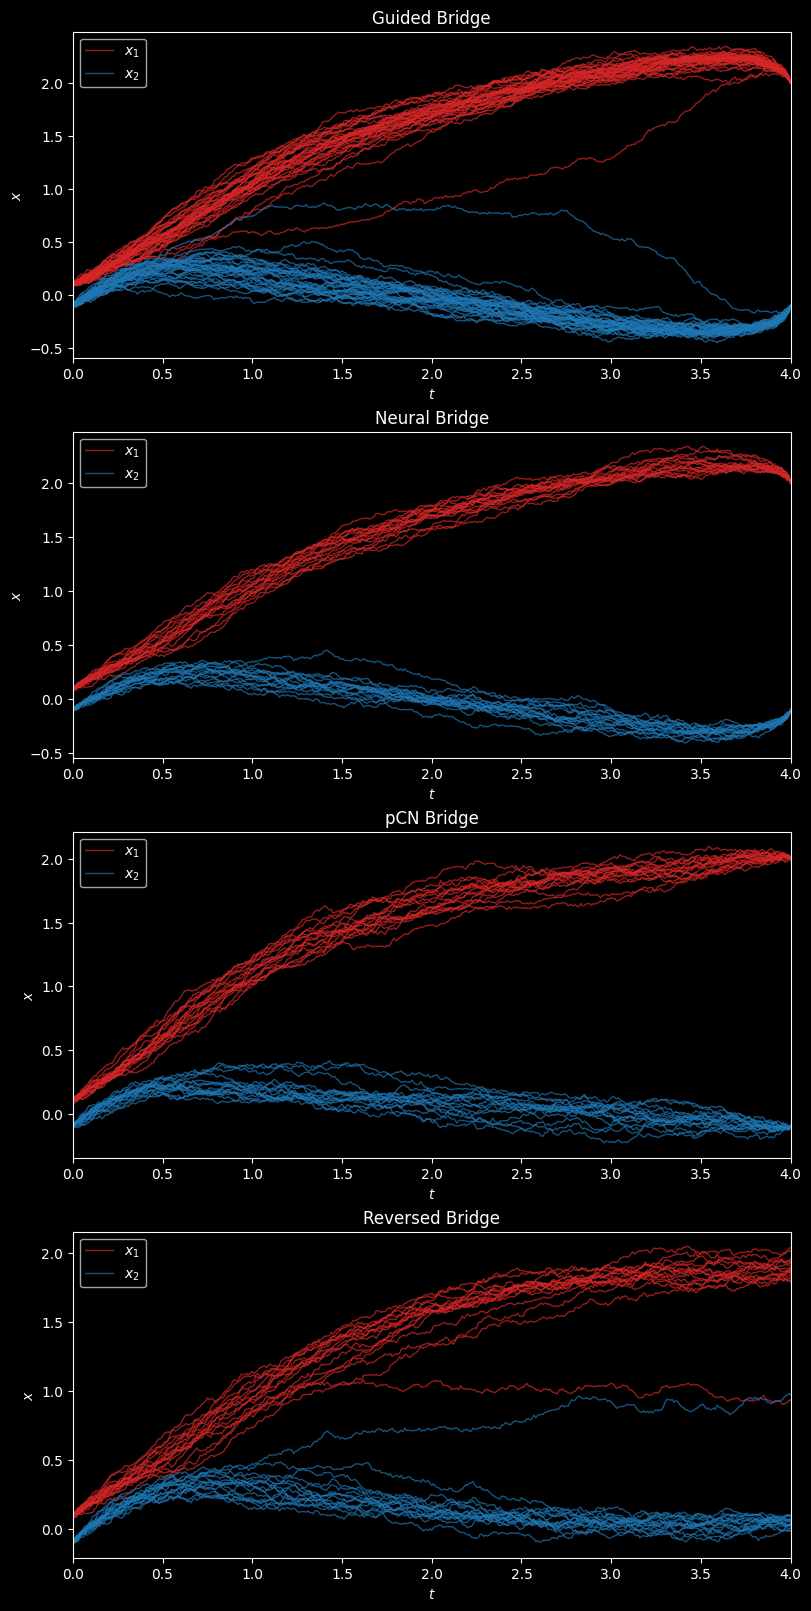

In [30]:
fig, ax = plt.subplots(4, 1, figsize=(8, 16), layout="constrained")
plot_sample_path(guided_bridge_path, ax=ax[0], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path_X, ax=ax[2], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(reversed_bridge_path, ax=ax[3], color=["tab:red", "tab:blue"], label=["$x_1$", "$x_2$"], title="Reversed Bridge")